In [1]:
import sys
import gpytorch
import numpy as np
import pandas as pd
import torch
from datetime import datetime, timedelta
from scipy.stats import qmc

from bo_methods_lib.GP_Vs_True import Compare_GP_True
from bo_methods_lib.GP_Vs_True_Sensitivity import Compare_GP_True_Movie
# from bo_methods_lib.GP_Validation import LOO_Analysis
from bo_methods_lib.bo_functions_generic import round_time, gen_theta_set,gen_x_set, find_train_doc_path, set_ep, clean_1D_arrays

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2023-03-30 13:15:00


In [2]:
#Set Date and Time
dateTimeObj = round_time()
timestampStr = dateTimeObj.strftime("%d-%b-%Y (%H:%M:%S)")
print("Date and Time: ", timestampStr)
# DateTime = dateTimeObj.strftime("%Y/%m/%d/%H-%M-%S%p")
DateTime = dateTimeObj.strftime("%Y/%m/%d/%H-%M")
print(DateTime)
# DateTime = "2022/11/29/09-48"
DateTime = None ##For Testing

Date and Time:  30-Mar-2023 (13:15:00)
2023/03/30/13-15


In [12]:
#Set Parameters
#Need to run at a and b, need 2 arrays to test that this will work
CS = 2.2

Bound_Cut = True
eval_Train = True

Constants = np.array([[-200,-100,-170,15],
                      [-1,-1,-6.5,0.7],
                      [0,0,11,0.6],
                      [-10,-10,-6.5,0.7],
                      [1,0,-0.5,-1],
                      [0,0.5,1.5,1]])
if CS == 2.2:
    skip_param_types = 1 #This is what changes for subpoint
    true_p = Constants[skip_param_types:skip_param_types+2].flatten()
    param_dict = {0 : 'a_1', 1 : 'a_2', 2 : 'a_3', 3 : 'a_4',
                  4 : 'b_1', 5 : 'b_2', 6 : 'b_3', 7 : 'b_4'}
    exp_d = 2
    if Bound_Cut == True:
        bounds_x = np.array([[-1.0, 0.0],
                            [   0.5, 1.5]])
        n = 25 #Number of experimental data points to use
    else:    
        bounds_x = np.array([[-1.5, -0.5],
                     [   1,    2]])
        n = 27 #Number of experimental data points to use
    bounds_p = np.array([[-2, -2, -10, -2, -2, -2,  5, -2],
                   [ 2,  2,   0,  2,  2,  2, 15,  2]])

else:
    Constants = true_p = np.array([1,-1])
    skip_param_types = 0
    param_dict = {0 : '\\theta_1', 1 : '\\theta_2'}
    exp_d = 1
    n = 5
    bounds_x = np.array([[-2], [2]])
    bounds_p = np.array([[-2, -2],
                         [ 2,  2]])

# print(Theta_True)
t = 20
# percentiles = np.linspace(-1.0,1.0,41)
percentiles = np.linspace(0,0,1)
d = len(true_p)
kernel_func = ["Mat_52"]
train_iter = 300
initialize = 2
noise_std = 0.1
set_lengthscale = np.linspace(1e-6,1.0,2)
set_lengthscale = [None]
verbose = False
norm = False

obj = "obj"

emulator =  True
save_figure = True
save_figure = False
save_csvs = False

if Bound_Cut == True:
    cut_bounds = '_cut_bounds'
else:
    cut_bounds = ""

#Pull Experimental data from CSV
exp_data_doc = 'Input_CSVs/Exp_Data/d='+str(exp_d)+'/n='+str(n)+cut_bounds+'.csv'
exp_data = np.array(pd.read_csv(exp_data_doc, header=0,sep=","))
Xexp = exp_data[:,1:exp_d+1]
Yexp = exp_data[:,-1]

Xexp = clean_1D_arrays(Xexp)

#Define GP Testing space
p=20
# print(bounds_x)
X_space = gen_x_set(LHS = False, n_points = p, dimensions = exp_d, bounds = bounds_x)
# print(X_space[-5:,:])

In [13]:
%%time
#Set Date and Time
dateTimeObj = datetime.now()
timestampStr = dateTimeObj.strftime("%d-%b-%Y (%H:%M:%S)")
print("Date and Time: ", timestampStr)
# DateTime = dateTimeObj.strftime("%Y/%m/%d/%H-%M-%S%p")
DateTime = dateTimeObj.strftime("%Y/%m/%d/%H-%M")
DateTime = None ##For Testing
print("Date and Time Saved: ", DateTime)
save_figure = True
save_csvs = True

t_use = int(t*n)
all_data_doc = find_train_doc_path(emulator, obj, d, t_use, bound_cut = Bound_Cut)
print(all_data_doc)
all_data = np.array(pd.read_csv(all_data_doc, header=0,sep=","))

Date and Time:  30-Mar-2023 (13:21:12)
Date and Time Saved:  None
Input_CSVs/Train_Data/d=8/all_emul_data/t=500_cut_bounds.csv
CPU times: user 3.11 ms, sys: 1.99 ms, total: 5.1 ms
Wall time: 4.01 ms


Init. Noise 1.000 
Init. Outputscale: 2.000
Init. Lengthscale of Best Restart 
 [10.9763 14.3038 12.0553 10.8977  8.4731 12.9179  8.7517 17.8355 19.2733
  7.6688]
Lengthscale [[3.90700e-01 3.12620e+00 3.63183e+01 2.95040e+00 1.41016e+01 1.66841e+01
  8.14390e+00 1.38129e+01 1.10654e+01 2.80000e-03]]
Noise for lengthscale 5.2257
Outputscale 21.4387
Base Theta Train for Movies: tensor([-1.1740, -1.6574, -9.8016, -1.5555,  0.6568,  0.0169, 14.5698, -0.1836])


KeyboardInterrupt: 

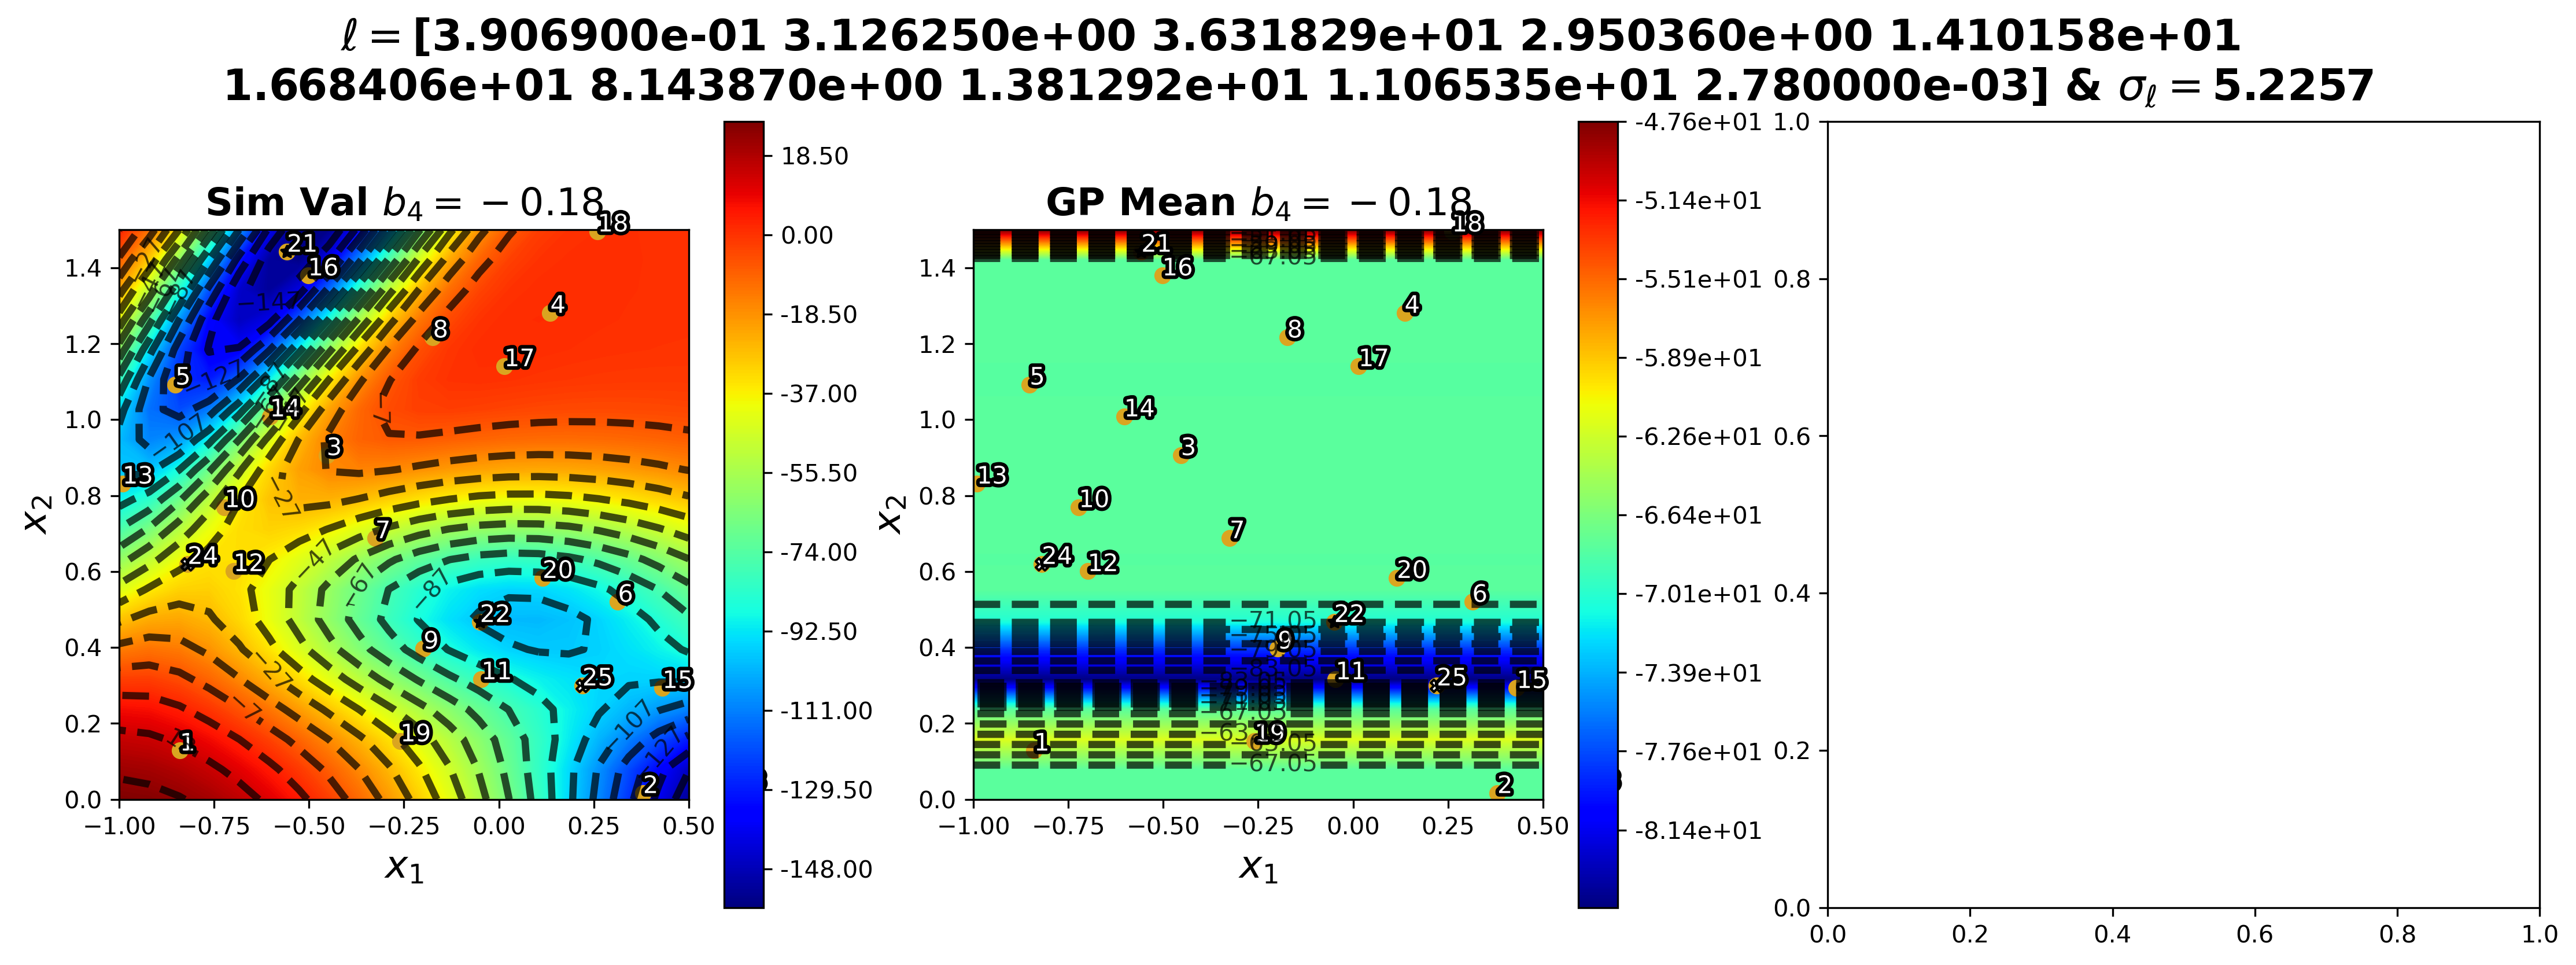

In [14]:
# Compare_GP_True(all_data, X_space, Xexp, Yexp, Constants, true_p, obj, CS, 
#                 skip_param_types, set_lengthscale, train_iter, noise_std, verbose, DateTime, 
#                 save_figure, eval_Train = eval_Train)
for set_lengthscl in set_lengthscale:
    for kernel in kernel_func:
        Compare_GP_True_Movie(all_data, X_space, Xexp, Yexp, Constants, true_p, CS, bounds_p, percentiles,
                skip_param_types, kernel, set_lengthscl, train_iter, initialize, noise_std, verbose, DateTime, 
                save_csvs, save_figure, eval_Train = eval_Train, CutBounds = Bound_Cut)